# 7 | Back-projection and Ray-plane Intersection (solution)
**ES143 Computer Vision, Harvard University**

Name: *(<font color=red>your name here</font>)*

<br>

---
In this independent coding task you will learn to:
* back-project a pixel $(x,y)$ to its corresponding ray in 3D space, $\tilde{\bf X}(\lambda)=(\lambda d_1,\lambda d_2,\lambda d_3),\lambda>0$
* intersect that ray with a 3D plane that has coordinates $\boldsymbol{\Pi}=(a,b,c,d)$.

The inputs required to complete the assignment can be found in the ZIP file that accompanies this notebook on Canvas. If you have not already done so, begin by creating copies of the notebook and the `.zip` file in your google drive at filepaths

`My Drive/es-143-assignments/M07/*`

As usual, it is important that the ZIP file is in the same folder as the notebook before you run the setup cells below, which unpack the archive into the expected location.

Small items marked with "<font color='red'>**To Do**</font>" require you to act and think but will not be evaluated. The section marked with "<font color='red'>**TASK**</font>" will be evaluated.

---

When you are done, post a screenshot of your plot to this [padlet](https://padlet.com/zickler/ray_plane_intersection). Then double-check that your notebook runs without error (i.e., `Restart session and run all`) and then generate an HTML file by the running the *Submission* cells [at the bottom of the notebook](#submission). Submit the HTML and `.ipynb` version of your notebook to Canvas with filenames of the form `LASTNAME_FIRSTNAME_M07-RayPlaneIntersection.{html,ipynb}`.

As usual, use of generative AI tools must adhere to the course policy as described in the [ES 143 Syllabus](https://canvas.harvard.edu/courses/129415/assignments/syllabus). In particular:
* You may not submit AI-generated code that you cannot explain, or whose validity and correctness you have not verified.
* Your use of generative AI tools must be documented in [the usual text cell](#ai-disclosure) near the bottom of the notebook.

---

# Setup

The next few cells mount your Google drive and unzip the assignment's input ZIP file. They also import some useful packages and configure figure sizes. Finally, they define some helper functions for plotting.

In [1]:
# Mount your google drive. This will launch a pop-up window for authentication.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# YOU SHOULD HAVE ALREADY COPIED THE ASSIGNMENT FILES TO THIS
# FOLDER ON YOUR GOOGLE DRIVE

%cd "/content/drive/My Drive/es-143-assignments/M07/"

/content/drive/My Drive/es-143-assignments/M07


In [3]:
# Extract zip file. This results in two images in a directory named ./data/
! unzip -n 7_RayPlaneIntersection.zip

Archive:  7_RayPlaneIntersection.zip
   creating: data2/
  inflating: data2/twoboards.jpg     
  inflating: data2/twoboards_withplanes.pkl  


In [4]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
import requests
import pickle
import glob   # filename and path management for file I/O

# import plotly
import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [5]:
#@title Helper functions (it is not necessary for you to understand these)

# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

def add_plotly_camera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# h,w:      height and width of image in pixels
# camera:   3x4 camera matrix
# raysize:  length of tetrahedral edges (in world units)
# fig:      pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])

    # Compute camera center (null vector of P)
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right

    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3],
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1),
        rcond=None)[0])

    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)

    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)

    #   desired ray segments that are length raysize in these directions
    V = np.tile(C, (4, 1)) + raysize * V

    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]],
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))

    return 1

def add_plotly_plane(plane,figobj):
# Add 3D plane to pyplot figure
# plane:   (a,b,c,d) plane parameters
# fig:      pyplot figure object
#
# Returns: 1
#
# Note: this function only works for this assignment's particular set of planes

    # create regular grid of X,Y,Z values that span the volume that is relevant to
    # this assignment's planes
    #   (numpy.mgrid trick: j (complex) in step size forces inclusion of stop value)
    X, Y, Z = np.mgrid[-5:5:40j, -9:5:40j, 10:21:40j]

    # evaluate the linear functions on this volumetric grid that is zero at the plane
    implicitplane = plane[0]*X + plane[1]*Y + plane[2]*Z + plane[3]

    # display using plotly's isosurface trace
    figobj.add_trace(go.Isosurface(
          x=X.flatten(),
          y=Y.flatten(),
          z=Z.flatten(),
          value=implicitplane.flatten(),
          isomin=0,
          isomax=0,
          opacity=0.3,
          colorscale='blues',
          showscale=False, # remove colorbar
          ))

    return 1

# Load and visualize the inputs

The following cell loads our now-familiar image `twoboards.jpg` as well as the variables that are stored in pickle file `twoboards_withplanes.pkl`. These variable are:

* `calMatrix`: calibration matrix ${\bf K}$ as returned by `cv2.calibrateCamera()`
* `distCoeffs`: distortion coefficients as returned by `cv2.calibrateCamera()`
* `imgpoints_fine`: $N\times 2$ array of pixel coordinates $(x_i,y_i)$ for detected fine-board fiducials
* `imgpoints_coarse`: $N\times 2$ array of pixel coordinates $(x_j,y_j)$ for detected coarse-board fiducials
* `plane_fine`: plane coordinates $\boldsymbol{\Pi}_\text{fine} = (a,b,c,d)$ for the fine board
* `plane_coarse`: plane coordinates $\boldsymbol{\Pi}_\text{coarse} = (a',b',c',d')$ for the coarse board

<font color='red'>**To Do**</font>: Run the cell and examine the output. Study the code and make sure you understand it. Understanding what these variables represent and how to use them will be essential to your task.

Fine plane: [-0.01  0.4  -0.91 18.95]
Coarse plane: [-0.05 -0.71 -0.71 13.95]
Distortion coefficients: [[ 0.19 -0.89  0.   -0.    1.2 ]]
Intrinsic camera matrix K:
 [[1014.74    0.    507.16]
 [   0.   1014.35  664.98]
 [   0.      0.      1.  ]]


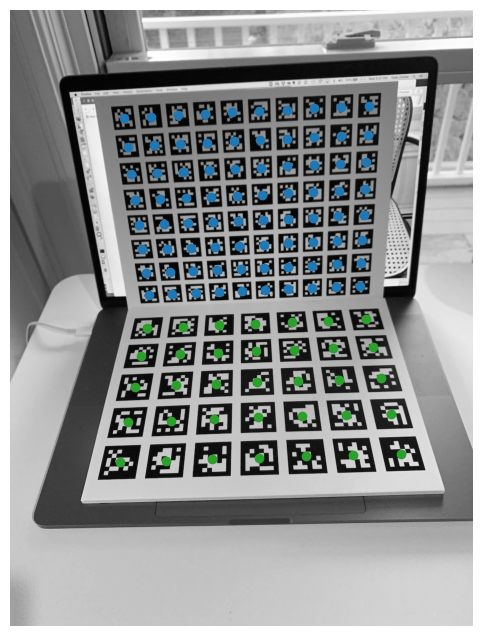

In [6]:
# load image with two AprilBoards (fine and coarse)
fname='./data2/twoboards.jpg'

# import calibration data, image points and two planes
data = pickle.load(open('./data2/twoboards_withplanes.pkl', 'rb'))

imgpoints_fine = data['imgpoints_fine']      # Nx2 array of image points (fine AprilBoard)
imgpoints_coarse = data['imgpoints_coarse']  # Nx2 array of image points (coarse AprilBoard)
calMatrix = data['calMatrix']                # K matrix
distCoeffs = data['distCoeffs']              # distortion coefficients
plane_fine = data['plane_fine']              # 1x4 plane coords \Pi_fine = (a,b,c,d)
plane_coarse = data['plane_coarse']          # 1x4 plane coords \Pi_coarse = (a,b,c,d)

# read image and convert to grayscale if necessary
orig = cv2.imread(fname)
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig

# print values
np.set_printoptions(precision=2, suppress=True)
print('Fine plane:', plane_fine)
print('Coarse plane:', plane_coarse)
print('Distortion coefficients:', distCoeffs)
print('Intrinsic camera matrix K:\n', calMatrix)

# display image and image points
fig,ax =  plt.subplots(figsize=(10,8))
plt.imshow(img / 255.0, cmap="gray")

ax.scatter(imgpoints_fine[:,0], imgpoints_fine[:,1],marker='o',color='#1f77b4')
ax.scatter(imgpoints_coarse[:,0], imgpoints_coarse[:,1],marker='o',color='#2ca02c')

plt.axis('off')
plt.show()

# <font color='red'>**TASK:**</font> Back-project pixels and compute ray-plane intersections

Your task is to edit the following cell by completing the function `intersect_ray_plane()`. Your function must back-project image points to their 3D rays and compute the 3D intersection points of these rays with a plane.

The function's arguments are
* `plane`: plane coordinates $(a,b,c,d)$
* `impts`: $N\times 2$ array of pixel coordinates $(x_i,y_i)$
* `calMatrix`: calibration matrix ${\bf K}$ as returned by `cv2.calibrateCamera()`
* `distCoeffs`: distortion coefficients as returned by `cv2.calibrateCamera()`

Your function should return an $N\times 3$ array of 3D point coordinates $(X_i,Y_i, Z_i)$ cooresponding to the $N$ ray-plane intersections.

Evaluate your code by running the test script that follows. This test script evaluates the output of your function qualitatively by plotting your intersection points as green and blue 3D points in a plotly figure that also contains a visualizion of the camera and the two planes $\boldsymbol{\Pi}_\text{fine},\boldsymbol{\Pi}_\text{coarse}$. (You may run the test script first before performing your edits to see how it works. The starter codes simply sets all of the intersection points to $(0,0,0)$, so they appear coincident with the camera center.)

When your implementation is correct, your intersection points will appear as two regular grids within their respective planes.

When you are satisfied with your results, take a screenshot of your test plot and post it to the padlet linked above.

In [7]:
def intersect_ray_plane(plane, impts, calMatrix, distCoeffs):
    """
    3D intersection points from back-projected camera rays and a 3D plane

    Args:
      plane:      (a,b,c,d) plane parameters in camera coordinate system
      impts:      Nx2 array of pixel coordinates (xi,yi) to be back-projected
      calMatrix:  K-matrix as returned by cv2.calibrateCamera()
      distCoeffs: optical distortion coefficients as returned by cv2.calibrateCamera()

    Returns:
      intersections:  Nx3 array of 3D intersection-point coordinates (Xi,Yi,Zi)
    """

    # TO DO: replace this line with your code
    intersections = np.zeros((impts.shape[0], 3))

    return intersections

In [8]:
### SOLUTION

def intersect_ray_plane(plane, impts, calMatrix, distCoeffs):
    """
    3D intersection points from back-projected camera rays and a 3D plane

    Args:
      plane:      (a,b,c,d) plane parameters in camera coordinate system
      impts:      Nx2 array of pixel coordinates (xi,yi) to be back-projected
      calMatrix:  K-matrix as returned by cv2.calibrateCamera()
      distCoeffs: optical distortion coefficients as returned by cv2.calibrateCamera()

    Returns:
      intersections:  Nx3 array of 3D intersection-point coordinates (Xi,Yi,Zi)
    """

    # compute normalized coordinates (analogous to K^{-1}*x)
    impts_norm = cv2.undistortPoints(impts, calMatrix, distCoeffs)

    # remove extraneous leading size-1 axis that openCV returns (annoying)
    impts_norm = np.squeeze(impts_norm)

    # back-projections are homogeneous versions of these
    backproj = in2hom(impts_norm)

    # ray-plane intersection (use equation derived from Class Session slides)
    intersections_lambda = -plane[3]/np.dot(backproj,plane[:3])
    intersections = np.expand_dims(intersections_lambda,axis=1)*backproj

    return intersections

In [9]:
#@title Test script

# compute intersections
intersections_fine = intersect_ray_plane(plane_fine, imgpoints_fine, calMatrix, distCoeffs)
intersections_coarse = intersect_ray_plane(plane_coarse, imgpoints_coarse, calMatrix, distCoeffs)

# create figure
fig = go.Figure()

# draw the camera P = K[I | 0] (since we are using a camera-centered coordinate system)
h,w = img.shape
P = np.hstack((calMatrix,np.zeros((3,1))))
add_plotly_camera(h,w,P,1,fig)

# draw the two planes
add_plotly_plane(plane_fine,fig)
add_plotly_plane(plane_coarse,fig)

# draw the computed intersections
fig.add_trace(go.Scatter3d(x=intersections_fine[:,0],
                           y=intersections_fine[:,1],
                           z=intersections_fine[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='#1f77b4'
                           )
                          ))

fig.add_trace(go.Scatter3d(x=intersections_coarse[:,0],
                           y=intersections_coarse[:,1],
                           z=intersections_coarse[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='#2ca02c'
                           )
                          ))


# adjust aspect ratio and initial viewing direction
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=2, z=3),
                  showlegend=False,
                  scene_camera=dict(
                      up=dict(x=0, y=-1, z=0),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1, y=-1, z=-5)
                  )
                  )

fig.show()

Output hidden; open in https://colab.research.google.com to view.

<a name="ai-disclosure"></a>
# Disclosure of use of Generative AI for this assignment

<br />

*OPTIONAL TO DO: Write your brief summary of Generative AI use here.*

<br />


<a name="submission"></a>
# Submission

The following cells generate an HTML version of your notebook in the `./submit` directory associated with this assignment on your google drive. Once it is generated, submit your `.html` and `.ipynb` files to the appropriate assignment on Canvas using filenames

 `LASTNAME1_LASTNAME2_L07-RayPlaneIntersection.{html,ipynb}`

**Important**: Remember to edit the filenames (either in the cells below or on your local computer after downloading) to match your name, and make sure that all cells execute properly (i.e., click Runtime -> Restart session and run all) before exporting to HTML.

In [10]:
!mkdir -p "submit"

In [15]:
# Convert to HTML. Before running this cell:
# 1. edit your name in this cell
# 2. make sure your notebook executes and is saved

!jupyter nbconvert --to html 7_RayPlaneIntersection_solution.ipynb --output-dir "submit" --output "7_RayPlaneIntersection_Solution.html"

[NbConvertApp] Converting notebook 7_RayPlaneIntersection_solution.ipynb to html
[NbConvertApp] Writing 981055 bytes to submit/7_RayPlaneIntersection_Solution.html
